In [2]:
from disentanglement_lib.data.ground_truth import ground_truth_data

In [3]:
import argparse
import numpy as np
import numpy.random as npr
import pandas as pd
import scipy
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib.transforms import Affine2D
import seaborn as sns
from scipy.spatial import distance
sns.set_style("white")

In [4]:
color_names = ["black",
               "windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)

In [5]:
os.environ['DISENTANGLEMENT_LIB_DATA'] = 'data'

In [6]:
from ortho_vae.load_dsprites import DSprites

In [7]:
data = DSprites([1, 2, 3, 4, 5])


In [8]:
data.latents_values.shape

(737280, 6)

In [9]:
raw_ys = pd.DataFrame(data.latents_values[:,1:])
names = ['shape', 'scale', 'orientation', 'positionX', 'positionY']
raw_ys.columns = names
# ys = data.latents_values[:,1:]
# names = ['shape', 'scale', 'orientation', 'positionX', 'positionY']
subset_cols = ['shape', 'scale', 'orientation']

In [10]:
pairplot_kws = {"s": 12,'alpha': 0.3}

In [108]:
# calculate ortho-score

def ortho_score(mu, n_draws=5000):
    stdmu = (mu-np.min(mu,axis=0)) / (np.max(mu,axis=0) - np.min(mu,axis=0))

    robust_k_prop = 0.001
#     K = np.int(robust_k_prop * stdmu.shape[0])

    maxs = np.max(stdmu, axis=0)
    mins = np.min(stdmu, axis=0)
    smps = (np.column_stack([npr.rand(n_draws) * (maxs[i]-mins[i]) + mins[i] 
                             for i in range(stdmu.shape[1])]))
    min_dist = np.min(distance.cdist(smps, stdmu), axis=1)
    # ortho = (torch.mean(min_dist,dim=0))
    ortho = np.max(min_dist,axis=0)
    return ortho

## Plot the raw dataset

In [126]:
subsmp_prop = 0.01
num_pts = raw_ys.shape[0

In [127]:
ys = raw_ys[subset_cols][npr.rand(num_pts) > 1-subsmp_prop]

0 1
0 2
1 2


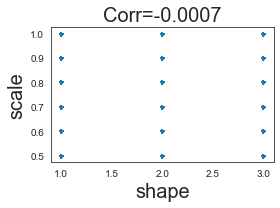

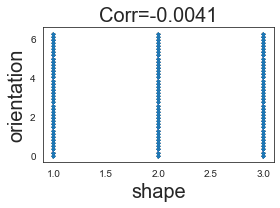

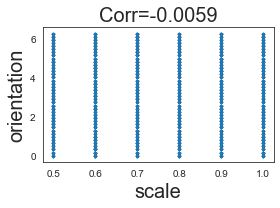

In [128]:
cols = list(ys.columns)
for i in range(len(cols)):
    for j in range(i+1,len(cols)):
        print(i,j)
        plt.figure(figsize=(4,3))
        plt.scatter(ys[cols[i]], ys[cols[j]], s=5, alpha=0.3)
        plt.xlabel(cols[i], fontsize=20)
        plt.ylabel(cols[j], fontsize=20)
        plt.title('Corr='+\
#             '\ncorr('+cols[i]+', '+cols[j]+')='+\
                  str(round(np.corrcoef(ys[cols[i]], \
                                        ys[cols[j]])[0,1],4)), fontsize=20)
        plt.tight_layout()
        plt.savefig('ys'+cols[i]+'_vs_'+cols[j]+'scatter.png')

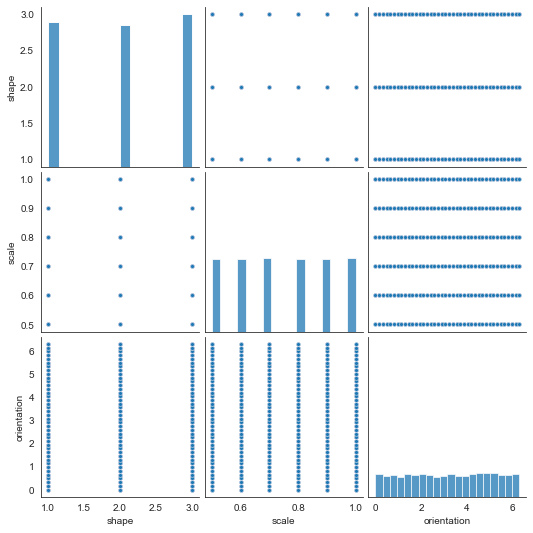

In [129]:

ys_pairplot = sns.pairplot(ys, plot_kws=pairplot_kws)
ys_pairplot.savefig('ys_pairplot.png')
# # sns.scatterplot(data=ys, x="shape", y="scale")

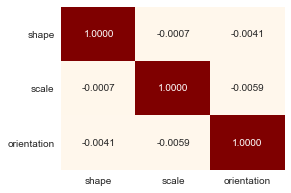

In [130]:
fig, ax = plt.subplots(figsize=(4,3))
sns.heatmap(ys.corr(method='pearson'), 
            annot=True, fmt='.4f', 
            cmap=plt.get_cmap('OrRd'), cbar=False, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
plt.savefig('ys_corrplot.pdf', bbox_inches='tight', pad_inches=0.0)

# ys_corrplot = corr.style.background_gradient()
# ys_corrplot.savefig('ys_corrplot.png')

In [131]:
ortho_score(np.array(ys))

0.2689816630922858

## Plot correlated but disentangled features

In [132]:
ys_sort = raw_ys.sort_values(by=names, ascending=False)

In [133]:
test_idx = list(np.arange(5000)) + list(npr.randint(raw_ys.shape[0], size=700))
test_ys = ys_sort[np.isin(np.arange(ys_sort.shape[0]),test_idx)][subset_cols]

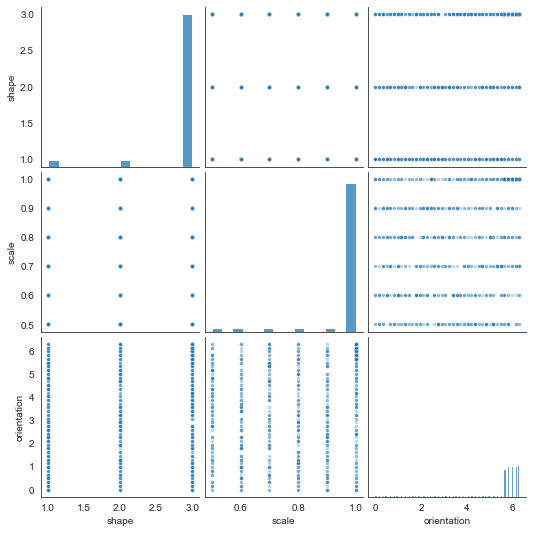

In [134]:
test_ys_pairplot = sns.pairplot(test_ys, plot_kws=pairplot_kws)
test_ys_pairplot.savefig('test_ys_pairplot.png')

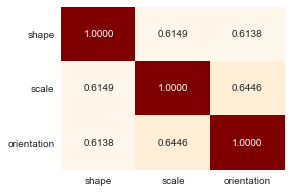

In [135]:
fig, ax = plt.subplots(figsize=(4,3))
sns.heatmap(test_ys.corr(method='pearson'), 
            annot=True, fmt='.4f', 
            cmap=plt.get_cmap('OrRd'), cbar=False, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
plt.savefig('test_ys_corrplot.pdf', bbox_inches='tight', pad_inches=0.0)

In [136]:
ortho_score(np.array(test_ys))

0.2666266156051077

0 1
0 2
1 2


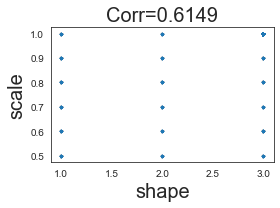

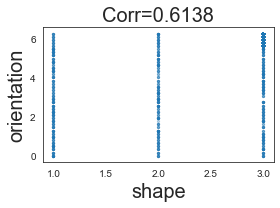

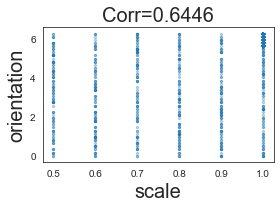

In [137]:
cols = list(test_ys.columns)
for i in range(len(cols)):
    for j in range(i+1,len(cols)):
        print(i,j)
        plt.figure(figsize=(4,3))
        plt.scatter(test_ys[cols[i]], test_ys[cols[j]], s=5, alpha=0.3)
        plt.xlabel(cols[i], fontsize=20)
        plt.ylabel(cols[j], fontsize=20)
        plt.title('Corr='+\
#             '\ncorr('+cols[i]+', '+cols[j]+')='+\
                  str(round(np.corrcoef(test_ys[cols[i]], \
                                        test_ys[cols[j]])[0,1],4)), fontsize=20)

        plt.tight_layout()
        plt.savefig('test_ys'+cols[i]+'_vs_'+cols[j]+'scatter.png')

## Plot entangled features

In [138]:
raw_ys['entangle1'] = 6 * raw_ys['shape']**1 + 8 * (raw_ys['scale']/raw_ys['scale'].std())**3 + 1 * (raw_ys['orientation']/raw_ys['orientation'].std())**3 + 0.2*npr.normal(size=raw_ys.shape[0])
raw_ys['entangle2'] = 12 * raw_ys['shape']**2 + 1 * (raw_ys['scale']/raw_ys['scale'].std())**2 + 8 * (raw_ys['orientation']/raw_ys['orientation'].std())**1 + 0.2*npr.normal(size=raw_ys.shape[0])
raw_ys['entangle3'] = 0 * raw_ys['shape']**3 + 4 * (raw_ys['scale']/raw_ys['scale'].std())**1 + 4 * (raw_ys['orientation']/raw_ys['orientation'].std())**2 + 0.2*npr.normal(size=raw_ys.shape[0])
entangle_cols = ['entangle1', 'entangle2', 'entangle3']
entangle_ys = raw_ys[entangle_cols][npr.rand(num_pts) > 1-subsmp_prop]

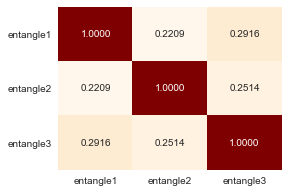

In [139]:
fig, ax = plt.subplots(figsize=(4,3))
sns.heatmap(entangle_ys.corr(method='pearson'), 
            annot=True, fmt='.4f', 
            cmap=plt.get_cmap('OrRd'), cbar=False, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
plt.savefig('entangle_ys_corrplot.pdf', bbox_inches='tight', pad_inches=0.0)

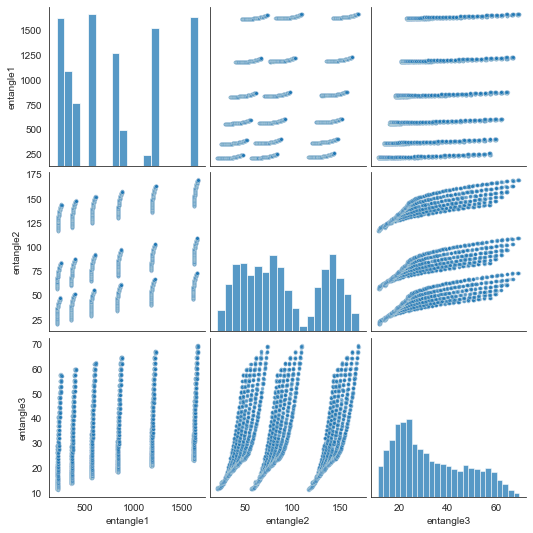

In [140]:
entangle_ys_pairplot = sns.pairplot(entangle_ys, plot_kws=pairplot_kws)
entangle_ys_pairplot.savefig('entangle_ys_pairplot.png')

In [141]:
ortho_score(np.array(entangle_ys))

0.34466930359278325

0 1
0 2
1 2


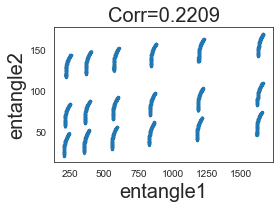

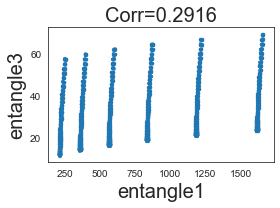

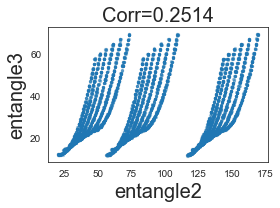

In [142]:
cols = list(entangle_ys.columns)
for i in range(len(cols)):
    for j in range(i+1,len(cols)):
        print(i,j)
        plt.figure(figsize=(4,3))
        plt.scatter(entangle_ys[cols[i]], entangle_ys[cols[j]], s=5, alpha=0.3)
        plt.xlabel(cols[i], fontsize=20)
        plt.ylabel(cols[j], fontsize=20)
        plt.title('Corr='+\
#             '\ncorr('+cols[i]+', '+cols[j]+')='+\
                  str(round(np.corrcoef(entangle_ys[cols[i]], \
                                        entangle_ys[cols[j]])[0,1],4)), fontsize=20)
        plt.tight_layout()
        plt.savefig('entangle_ys'+cols[i]+'_vs_'+cols[j]+'scatter.png')